In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input , Dense , Flatten , Dropout , BatchNormalization
from tensorflow.keras.layers import Conv2D , SeparableConv1D , ReLU , Activation , MaxPool2D
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from PIL import Image
import os
import cv2 as cv 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
import itertools
import tensorflow_hub as hub
from tensorflow.keras.applications.resnet50 import ResNet50


print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.7.0
Hub version: 0.12.0
GPU is available


In [2]:
model_name = "resnet_v2_50"

model_handle_map = {
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"}
model_image_size_map = {"resnet_v2_50": 256}

In [3]:
model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 256)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32
EPOCHS = 7

Selected model: resnet_v2_50 : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Input size (256, 256)


In [4]:
train_directory = 'chest_xray/train'
test_directory = 'chest_xray/test'

train_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=3, validation_split=0.1, subset='training',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)
    
validation_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=3, validation_split=0.1, subset='validation',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)    


test_data = tf.keras.utils.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=3, interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 5232 files belonging to 2 classes.
Using 4709 files for training.
Found 5232 files belonging to 2 classes.
Using 523 files for validation.
Found 624 files belonging to 2 classes.


In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_validation = validation_data.map(lambda x, y: (normalization_layer(x), y))
normalized_test = test_data.map(lambda x, y: (normalization_layer(x), y))

do_fine_tuning = False

In [6]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation="sigmoid")
])
#model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 4,098
Non-trainable params: 23,564,800
_________________________________________________________________


In [7]:
#סעיף ז - סעיפים א',ב,ג

In [8]:
model.compile(loss="BinaryCrossentropy", optimizer="adam", metrics=["accuracy"])

model_history = model.fit(normalized_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data= normalized_validation)

Epoch 1/7
148/148 [==============================] - 21s 105ms/step - loss: 0.2548 - accuracy: 0.9019 - val_loss: 0.1289 - val_accuracy: 0.9446
Epoch 2/7
148/148 [==============================] - 15s 97ms/step - loss: 0.1337 - accuracy: 0.9518 - val_loss: 0.1131 - val_accuracy: 0.9522
Epoch 3/7
148/148 [==============================] - 15s 97ms/step - loss: 0.1124 - accuracy: 0.9588 - val_loss: 0.0870 - val_accuracy: 0.9637
Epoch 4/7
148/148 [==============================] - 15s 97ms/step - loss: 0.0933 - accuracy: 0.9656 - val_loss: 0.0845 - val_accuracy: 0.9637
Epoch 5/7
148/148 [==============================] - 15s 98ms/step - loss: 0.0836 - accuracy: 0.9698 - val_loss: 0.0714 - val_accuracy: 0.9732
Epoch 6/7
148/148 [==============================] - 15s 97ms/step - loss: 0.0802 - accuracy: 0.9718 - val_loss: 0.0630 - val_accuracy: 0.9790
Epoch 7/7
148/148 [==============================] - 15s 97ms/step - loss: 0.0771 - accuracy: 0.9735 - val_loss: 0.0602 - val_accuracy: 0.980

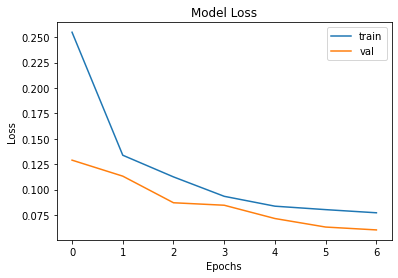

In [9]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

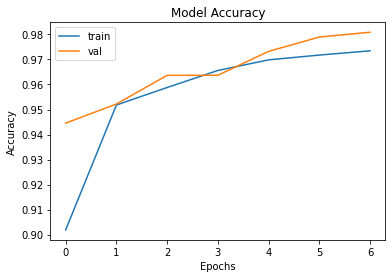

In [10]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])
plt.show()

In [11]:
predictions = np.array([])
test_labels = np.array([])
for x, y in normalized_test:
    predictions = np.concatenate([predictions,np.argmax(model.predict(x),axis = -1)])
    test_labels = np.concatenate([test_labels,np.argmax(y.numpy(),axis = -1)])

<Figure size 432x288 with 0 Axes>

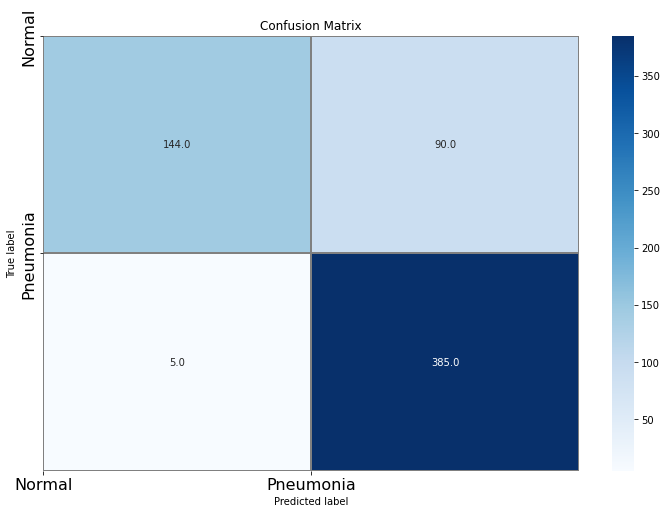

In [12]:
cm  = confusion_matrix(test_labels, predictions)
plt.figure()
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [13]:
tn,fp,fn,tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.99
Precision of the model is 0.81


In [14]:
#סעיף ז - סעיף ה' הורדת היפרפרמטר 

In [15]:
print("Building model with", model_handle)
newmodelnoD = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation="sigmoid")
])
newmodelnoD.summary()

Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 4,098
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
newmodelnoD.compile(loss="BinaryCrossentropy", optimizer="adam", metrics=["accuracy"])

newmodelnoD_history = newmodelnoD.fit(normalized_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data= normalized_validation)

Epoch 1/7
148/148 [==============================] - 17s 98ms/step - loss: 0.2123 - accuracy: 0.9219 - val_loss: 0.1250 - val_accuracy: 0.9484
Epoch 2/7
148/148 [==============================] - 14s 95ms/step - loss: 0.1151 - accuracy: 0.9607 - val_loss: 0.0916 - val_accuracy: 0.9579
Epoch 3/7
148/148 [==============================] - 15s 97ms/step - loss: 0.0938 - accuracy: 0.9679 - val_loss: 0.0773 - val_accuracy: 0.9656
Epoch 4/7
148/148 [==============================] - 15s 97ms/step - loss: 0.0808 - accuracy: 0.9720 - val_loss: 0.0733 - val_accuracy: 0.9713
Epoch 5/7
148/148 [==============================] - 15s 97ms/step - loss: 0.0709 - accuracy: 0.9756 - val_loss: 0.0615 - val_accuracy: 0.9828
Epoch 6/7
148/148 [==============================] - 15s 97ms/step - loss: 0.0635 - accuracy: 0.9773 - val_loss: 0.0700 - val_accuracy: 0.9771
Epoch 7/7
148/148 [==============================] - 15s 97ms/step - loss: 0.0583 - accuracy: 0.9807 - val_loss: 0.0544 - val_accuracy: 0.9866

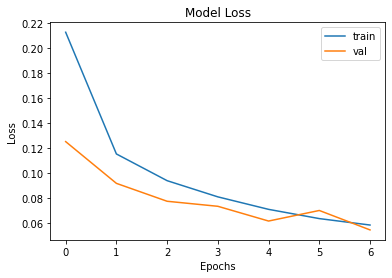

In [17]:
plt.plot(newmodelnoD_history.history['loss'])
plt.plot(newmodelnoD_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

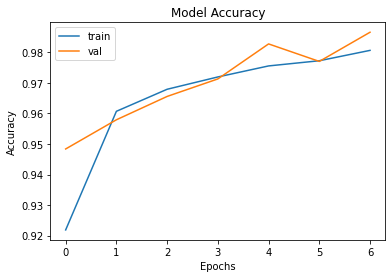

In [18]:
plt.plot(newmodelnoD_history.history['accuracy'])
plt.plot(newmodelnoD_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])
plt.show()

In [19]:
predictions = np.array([])
test_labels = np.array([])
for x, y in normalized_test:
    predictions = np.concatenate([predictions,np.argmax(newmodelnoD.predict(x),axis = -1)])
    test_labels = np.concatenate([test_labels,np.argmax(y.numpy(),axis = -1)])

<Figure size 432x288 with 0 Axes>

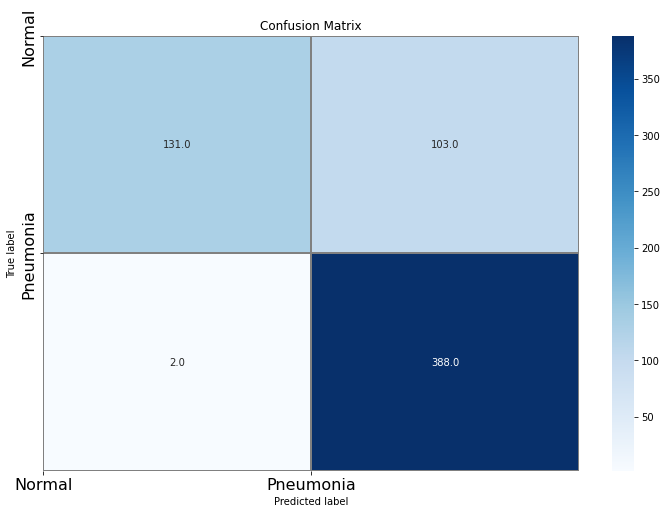

In [20]:
cm  = confusion_matrix(test_labels, predictions)
plt.figure()
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [21]:
tn,fp,fn,tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.99
Precision of the model is 0.79


In [22]:
#סעיף ח' - ניסיון אימון שכבות באמצע

In [23]:
Resnet_Model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (256,256,3))
for layer in Resnet_Model.layers[:40]:
    layer.trainable = False
for layer in Resnet_Model.layers[40:70]:
    layer.trainable = True
for layer in Resnet_Model.layers[70:]:
    layer.trainable = False
Resnet_Model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [24]:
Resnet_Model.get_config()

C:\Users\Jonathan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


{'name': 'resnet50',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_3'},
   'name': 'input_3',
   'inbound_nodes': []},
  {'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': False,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'name': 'conv1_pad',
   'inbound_nodes': [[['input_3', 0, 0, {}]]]},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv1_conv',
    'trainable': False,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}

In [25]:
print("Building model with", model_handle)
Train_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    Resnet_Model,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation="sigmoid")
])
#model.build((None,)+IMAGE_SIZE+(3,))
Train_model.summary()

Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                 262146    
                                                                 
Total params: 23,849,858
Trainable params: 1,171,586
Non-trainable params: 22,678,272
_________________________________________________________________


In [26]:
Train_model.compile(loss="BinaryCrossentropy", optimizer="adam", metrics=["accuracy"])

Train_model_history = Train_model.fit(normalized_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data= normalized_validation)

Epoch 1/7
148/148 [==============================] - 35s 211ms/step - loss: 0.4212 - accuracy: 0.9242 - val_loss: 7.5363 - val_accuracy: 0.7725
Epoch 2/7
148/148 [==============================] - 31s 207ms/step - loss: 0.1315 - accuracy: 0.9614 - val_loss: 2.5372 - val_accuracy: 0.7725
Epoch 3/7
148/148 [==============================] - 31s 207ms/step - loss: 0.1993 - accuracy: 0.9601 - val_loss: 1.4873 - val_accuracy: 0.7839
Epoch 4/7
148/148 [==============================] - 31s 206ms/step - loss: 0.1030 - accuracy: 0.9718 - val_loss: 0.5738 - val_accuracy: 0.8967
Epoch 5/7
148/148 [==============================] - 31s 207ms/step - loss: 0.0725 - accuracy: 0.9781 - val_loss: 2.6830 - val_accuracy: 0.7878
Epoch 6/7
148/148 [==============================] - 31s 207ms/step - loss: 0.0800 - accuracy: 0.9786 - val_loss: 4.6652 - val_accuracy: 0.7725
Epoch 7/7
148/148 [==============================] - 31s 207ms/step - loss: 0.0421 - accuracy: 0.9892 - val_loss: 0.3114 - val_accuracy:

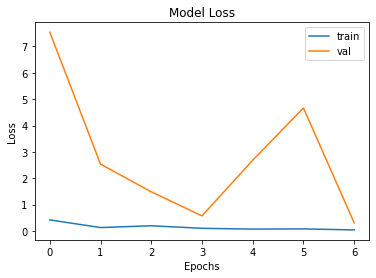

In [27]:
plt.plot(Train_model_history.history['loss'])
plt.plot(Train_model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

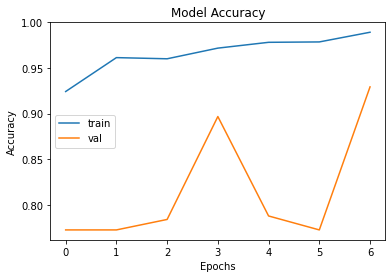

In [28]:
plt.plot(Train_model_history.history['accuracy'])
plt.plot(Train_model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])
plt.show()

In [29]:
predictions = np.array([])
test_labels = np.array([])
for x, y in normalized_test:
    predictions = np.concatenate([predictions,np.argmax(Train_model.predict(x),axis = -1)])
    test_labels = np.concatenate([test_labels,np.argmax(y.numpy(),axis = -1)])


<Figure size 432x288 with 0 Axes>

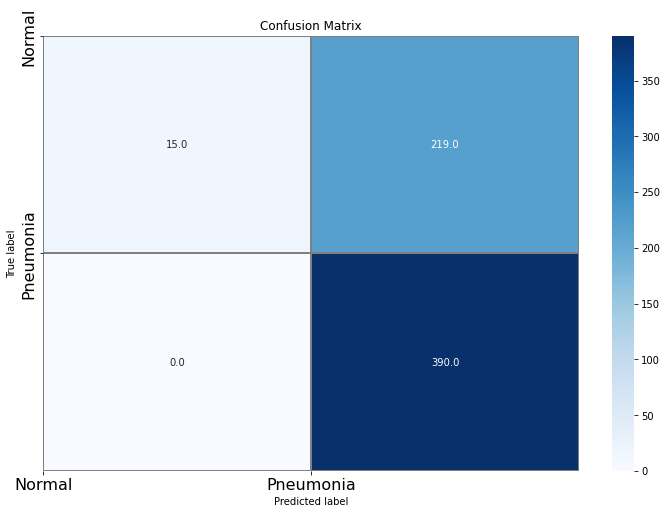

In [30]:
cm  = confusion_matrix(test_labels, predictions)
plt.figure()
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [31]:
tn,fp,fn,tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 1.00
Precision of the model is 0.64


In [32]:
#כעת ננסה לאמן שכבות אחרונות 

In [33]:
Resnet_Model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (256,256,3))
for layer in Resnet_Model.layers[:165]:
    layer.trainable = False
for layer in Resnet_Model.layers[165:]:
    layer.trainable = True
Resnet_Model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [34]:
Resnet_Model.get_config()

C:\Users\Jonathan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


{'name': 'resnet50',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_5'},
   'name': 'input_5',
   'inbound_nodes': []},
  {'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': False,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'name': 'conv1_pad',
   'inbound_nodes': [[['input_5', 0, 0, {}]]]},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv1_conv',
    'trainable': False,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}

In [35]:
print("Building model with", model_handle)
Train_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    Resnet_Model,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation="sigmoid")
])
#model.build((None,)+IMAGE_SIZE+(3,))
Train_model.summary()

Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 2)                 262146    
                                                                 
Total params: 23,849,858
Trainable params: 4,727,810
Non-trainable params: 19,122,048
_________________________________________________________________


In [36]:
Train_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Train_model_history = Train_model.fit(normalized_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data= normalized_validation)

Epoch 1/7
148/148 [==============================] - 20s 117ms/step - loss: 0.5920 - accuracy: 0.8607 - val_loss: 0.5016 - val_accuracy: 0.7820
Epoch 2/7
148/148 [==============================] - 18s 118ms/step - loss: 0.2230 - accuracy: 0.9191 - val_loss: 7.7013 - val_accuracy: 0.2275
Epoch 3/7
148/148 [==============================] - 18s 117ms/step - loss: 0.1583 - accuracy: 0.9469 - val_loss: 2.7987 - val_accuracy: 0.2562
Epoch 4/7
148/148 [==============================] - 18s 117ms/step - loss: 0.1478 - accuracy: 0.9480 - val_loss: 0.1128 - val_accuracy: 0.9751
Epoch 5/7
148/148 [==============================] - 17s 115ms/step - loss: 0.1894 - accuracy: 0.9403 - val_loss: 7.0638 - val_accuracy: 0.2294
Epoch 6/7
148/148 [==============================] - 18s 117ms/step - loss: 0.1231 - accuracy: 0.9582 - val_loss: 0.8056 - val_accuracy: 0.7438
Epoch 7/7
148/148 [==============================] - 18s 116ms/step - loss: 0.1599 - accuracy: 0.9512 - val_loss: 50.9682 - val_accuracy

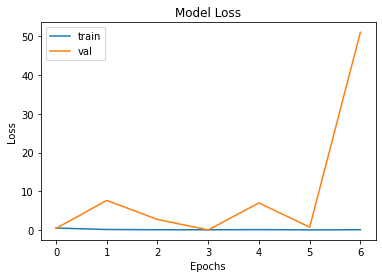

In [37]:
plt.plot(Train_model_history.history['loss'])
plt.plot(Train_model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

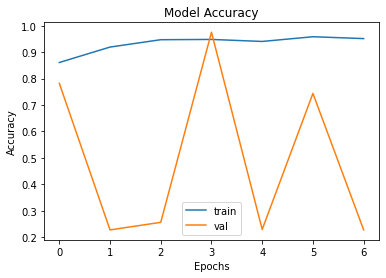

In [38]:
plt.plot(Train_model_history.history['accuracy'])
plt.plot(Train_model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])
plt.show()

In [39]:
predictions = np.array([])
test_labels = np.array([])
for x, y in normalized_test:
    predictions = np.concatenate([predictions,np.argmax(Train_model.predict(x),axis = -1)])
    test_labels = np.concatenate([test_labels,np.argmax(y.numpy(),axis = -1)])


<Figure size 432x288 with 0 Axes>

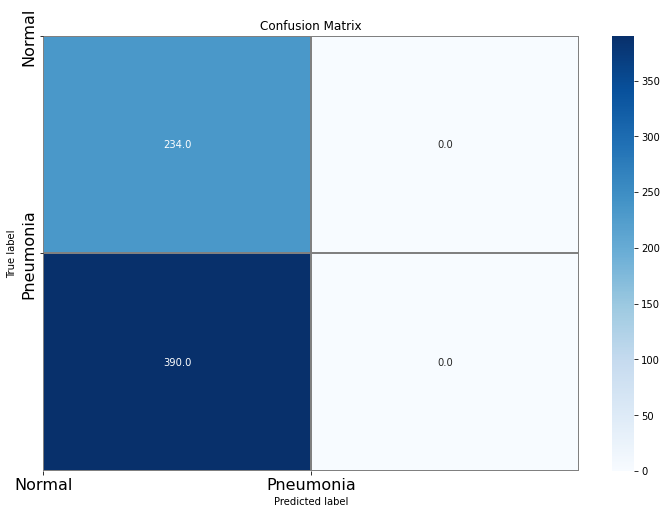

In [40]:
cm  = confusion_matrix(test_labels, predictions)
plt.figure()
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [41]:
tn,fp,fn,tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.00
Precision of the model is nan


<ipython-input-41-e15d671a0c05>:3: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp/(tp+fp)


In [42]:
#סעיף ט' - הוספת אוגמנטציות

In [43]:
train_normal = 'chest_xray/train/NORMAL'
train_pneumonia = 'chest_xray/train/PNEUMONIA'

In [44]:
train_img_count = 0

for y in train_data:
    train_img_count += 32

print(train_img_count)


4736


In [45]:
conut_normal= 0

for y in train_normal:
    conut_normal += 32

print(conut_normal)


736


In [46]:
count_pneumonia = 0

for y in train_pneumonia:
    count_pneumonia += 32

print(count_pneumonia)


832


In [47]:
weight_for_0 = (1 / conut_normal)*(train_img_count)/2.0
weight_for_1 = (1 / count_pneumonia)*(train_img_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 3.22
Weight for class 1: 2.85


In [48]:
print("Building model with", model_handle)
model_improvment = tf.keras.Sequential([
    
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation="sigmoid")
])

model_improvment.summary()

Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 4,098
Non-trainable params: 23,564,800
_________________________________________________________________


In [49]:
model_improvment.compile(loss="BinaryCrossentropy", optimizer="adam", metrics=["accuracy"])

model_improvment_history = model_improvment.fit(normalized_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data= normalized_validation, class_weight=class_weight)

Epoch 1/7
148/148 [==============================] - 17s 97ms/step - loss: 0.6631 - accuracy: 0.9223 - val_loss: 0.1241 - val_accuracy: 0.9446
Epoch 2/7
148/148 [==============================] - 15s 98ms/step - loss: 0.3907 - accuracy: 0.9537 - val_loss: 0.0897 - val_accuracy: 0.9598
Epoch 3/7
148/148 [==============================] - 15s 98ms/step - loss: 0.3103 - accuracy: 0.9633 - val_loss: 0.0752 - val_accuracy: 0.9656
Epoch 4/7
148/148 [==============================] - 14s 96ms/step - loss: 0.2760 - accuracy: 0.9656 - val_loss: 0.0751 - val_accuracy: 0.9751
Epoch 5/7
148/148 [==============================] - 15s 97ms/step - loss: 0.2423 - accuracy: 0.9694 - val_loss: 0.0654 - val_accuracy: 0.9828
Epoch 6/7
148/148 [==============================] - 15s 98ms/step - loss: 0.2294 - accuracy: 0.9739 - val_loss: 0.0630 - val_accuracy: 0.9847
Epoch 7/7
148/148 [==============================] - 15s 99ms/step - loss: 0.2179 - accuracy: 0.9741 - val_loss: 0.0595 - val_accuracy: 0.9828

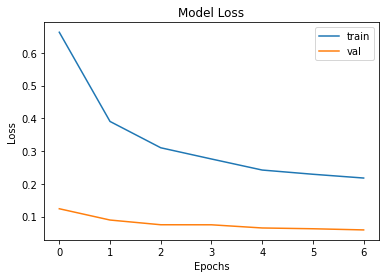

In [50]:
plt.plot(model_improvment_history.history['loss'])
plt.plot(model_improvment_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

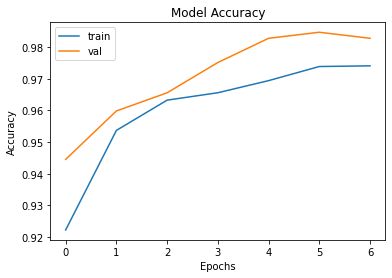

In [51]:
plt.plot(model_improvment_history.history['accuracy'])
plt.plot(model_improvment_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])
plt.show()

In [52]:
predictions = np.array([])
test_labels = np.array([])
for x, y in normalized_test:
    predictions = np.concatenate([predictions,np.argmax(model_improvment.predict(x),axis = -1)])
    test_labels = np.concatenate([test_labels,np.argmax(y.numpy(),axis = -1)])

<Figure size 432x288 with 0 Axes>

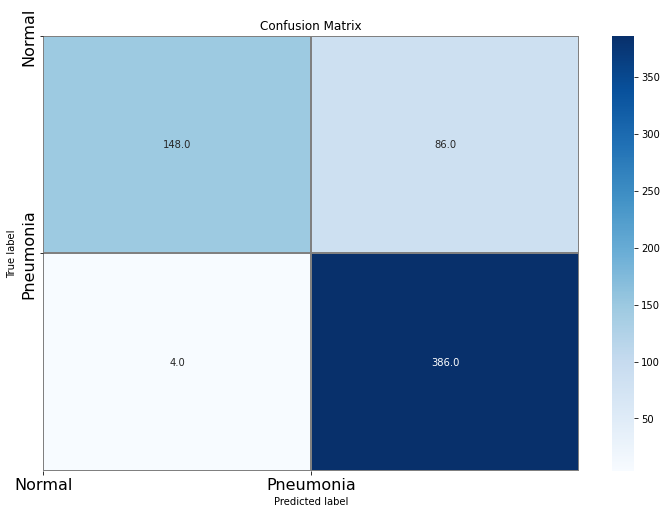

In [53]:
cm  = confusion_matrix(test_labels, predictions)
plt.figure()
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [54]:
tn,fp,fn,tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.99
Precision of the model is 0.82
